# FIT5201: Assessment 3
## Latent Variables and Neural Networks

## Objectives
This assignment consists of three parts (A,B,C), which cover latent variables models and neural networks (Modules 4 and 5). The total marks of this assessment is 100.

# Part A. Document Clustering
In this part, you solve a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation Maximization for document clustering.

## Question 1 [EM for Document Clustering, 40 Marks]
**Q1.1)** Derive Expectation and Maximisation steps of the hard-EM algorithm for Document Clustering, show your work.

Hard Expectation-Maximisation Algorithm

**Document Pre-processing**
	Create a word-document frequency matrix. 
	Remove stop words.
	Remove punctuation marks.
	Stem words.
	Remove numbers.
	Trim all whitespace.

**Hard Expectation-Maximisation Steps**

<u>Initialisation:</u>

1) Initialise the parameters 
$$
\theta^{old}=\ (\varphi^{old},\ \mu_1,\ \mu_2,...,\mu_k)
$$

Where all elements in $\varphi^{old}$ is 1/K where K = number of clusters, and µ is a matrix of random uniform numbers whose row sums up to 1.

<u>Expectation:</u>
 
2) For each document n, find the log probability $\gamma\left(z_{n,k}\right)$ (i.e. the probability that document n belongs to cluster k).
$$
\ln{\gamma\left(z_{n,k}\right)}=\Sigma_{n=1}^N\Sigma_{k=1}^K\left(\ln{\varphi_k+\ \Sigma_{w\in\mathcal{A}}c\left(w,n\right)ln}\mu_{k,w}\right)
$$

Where 
$\gamma\left(z_{n,k}\right)$ is the posterior probability of document n belonging to cluster k, 
$\varphi_k$ is the prior probability or the mixing components of cluster k, 
$c\left(w,n\right)$  is the frequency of the word w in document n and 
$\mu_{k,w}$ is the word proportion of the word w for each cluster k.


3) Derive $z_{n,k}$ by setting the cluster with the highest value of γ(zn,k) to 1 and the remaining γ(zn,k) to 0.

$$
z_{n,k} = \{1 \text{  for  argmax(γ(z_n))},   0 \text{   otherwise }\}
$$

<u>Maximisation:</u>

4) For each cluster k, calculate the following:

$$
\varphi_k=\frac{\sum_{n=1}^{N}z_{n,k}}{N}
$$
Where $\varphi_k$ is the prior probability of cluster k (or the proportion of documents n belonging to cluster k),

and N is the total number of documents.

In other terms:
$$
\varphi_k=\frac{total\ number\ of\ documents\ that\ belong\ to\ cluster\ k}{total\ number\ of\ documents}
$$

As well as the word proportion parameters for each word w in cluster k
$$
\mu_{k,w}=\ \frac{\sum_{n=1}^{N}{{(z}_{n,k})c(w,\ n)}}{\sum_{w\ \in\mathcal{A}}\sum_{n=1}^{N}{\left(z_{n,k}\right)c(w^\prime,\ n)}}\ \ 
$$

Where $\ \  
   z_{n,k}\ast c(w,\ n)$ is the number of times the word w appeared in cluster k,
and $\sum_{w\ \in\mathcal{A}}\sum_{n=1}^{N}{\left(z_{n,k}\right)c(w^\prime,\ n)}$ pertains to the total number of words for that cluster k. Note that the total number of words should consider repetitions (e.g. if the word ‘matinee’ appeared twice then 2 should be added to the total number).

In other terms:
$$
\mu_{k,w}=\ \frac{number\ of\ times\ word\ w\ appeared\ in\ k}{total\ number\ of\ word\ occurences\ in\ k}
$$

5) Set the new parameters with the values computed in step 4.

6) Repeat steps 2 to 5 until convergence or maximum number of iterations is reached.


**Q1.2)** Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.
__Hint.__ If it helps, feel free to base your code on the provided code for EM algorithm for GMM in Activity 4.1).

In [1]:
# --------------------------------------
#
# Code is from the code base provided.
#
# --------------------------------------

eps=1e-10
  
# reading the data
read.data <- function(file.name='./assessments_datasets/Task3A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
  
  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2*q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# Student needs to modify this function if wants to make it Hard-EM 
# gamma : N x K matrix, N = number of documents K = number of clusters
# model: rho: a K x 1 matrix that indicates the sizes of per cluster || mu: k x w the proportion of each word per cluster
# counts: the word document frequency matrix
# for soft EM, this computes for the probabilities of each document in N belonging to cluster K (meaning, sum of a row is 1)
# for hard EM, this determines the cluster K to where the document N belongs (meaning per row, one column will have 1, others 0)
E.step <- function(gamma, model, counts, mode = 1){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the p(N|K)
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
      
    # For hard clustering, set the highest probability to 1, others 0
    if (mode == 2){
      index <- which.max(gamma[n,])
      gamma[n, index] <- 1
      gamma[n, -index] <- 0
    }
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters

 
  # M step: Student needs to write this part for soft/hard EM
  #......
  # FOR DEBUG
  #gamma[1,] <- c(1,0,0,0)
  #gamma[2,] <- c(0,1,0,0)
  #gamma[3,] <- c(1,0,0,0)
  #gamma[4,] <- c(1,0,0,0)
  #gamma[5,] <- c(0,0,0,1)
  #gamma[6,] <- c(0,0,1,0)
  
  for(k in 1:K){
    # rho is the number of documents n that belongs to k over the total number of documents   
    model$rho[k,1] <- (sum(gamma[,k]))/N
      
    # word counts - w x n
    # gamma - n x k
    # wordcount - w x k (i.e. w x 1 since we're iterating per k)
    wordcount.per.cluster <- (counts %*% gamma[,k]) + eps
    
    # total words per cluster  
    total.words.per.cluster <- sum(wordcount.per.cluster) + W * eps
      
    # mu - k x w (i.e. 1 x w )
    model$mu[k,] <- wordcount.per.cluster/total.words.per.cluster
  }
  #
  # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
  # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
  # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
  # this prevents NaN for vectors where all elements aer zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
  # results in the uniform distribution after normalisation.  


  # Return the result
  return (model)
}

##--- EM for Document Clustering --------------------------------------------
EM <- function(counts, K=4, max.epoch=10, mode=1, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step(gamma, model, counts, mode)
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

**Q1.3)** Load __Task3A.text__ file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

**Q1.4)** Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM, and visualise the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2).

Warning message:
"package 'tm' was built under R version 3.3.3"Loading required package: NLP


[1] 2179929
[1] 1950803
[1] 1935163
[1] 1924662
[1] 1919813
[1] 1919019
[1] 1918656
[1] 1918381
[1] 1918007
[1] 1917707
[1] 1917390
[1] 1916940
[1] 1916330
[1] 1915535
[1] 1914636
[1] 1914114
[1] 1913648
[1] 1912920
[1] 1912564
[1] 1912260
[1] 1912113


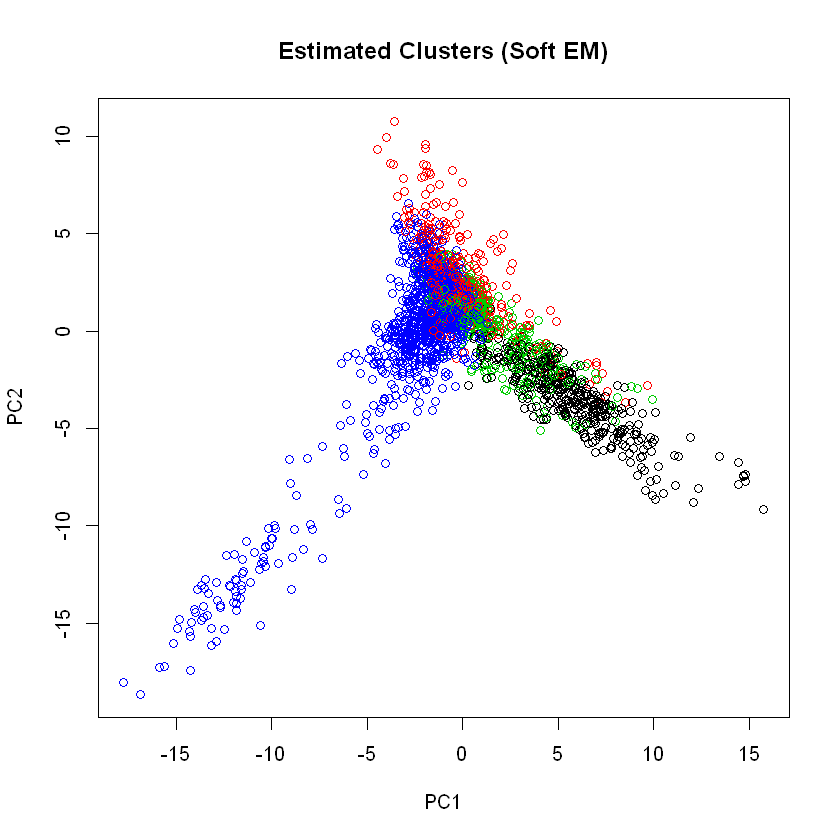

In [2]:
### main body ##################################################################

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./Task3A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
#counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)

# calling the EM algorithm on the data
res <- EM(counts, K=4, max.epoch=20)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Soft EM)')

## visualize the real clusters
#cluster.viz(t(counts), factor(data$label), 'Real Clusters')


[1] 2181355
[1] 1958552
[1] 1948296
[1] 1943007
[1] 1941333
[1] 1940280
[1] 1938591
[1] 1937008
[1] 1935931
[1] 1935167
[1] 1934916
[1] 1934835
[1] 1934767
[1] 1934763
[1] 1934763
[1] 1934763
[1] 1934763
[1] 1934763
[1] 1934763
[1] 1934763
[1] 1934763


NULL

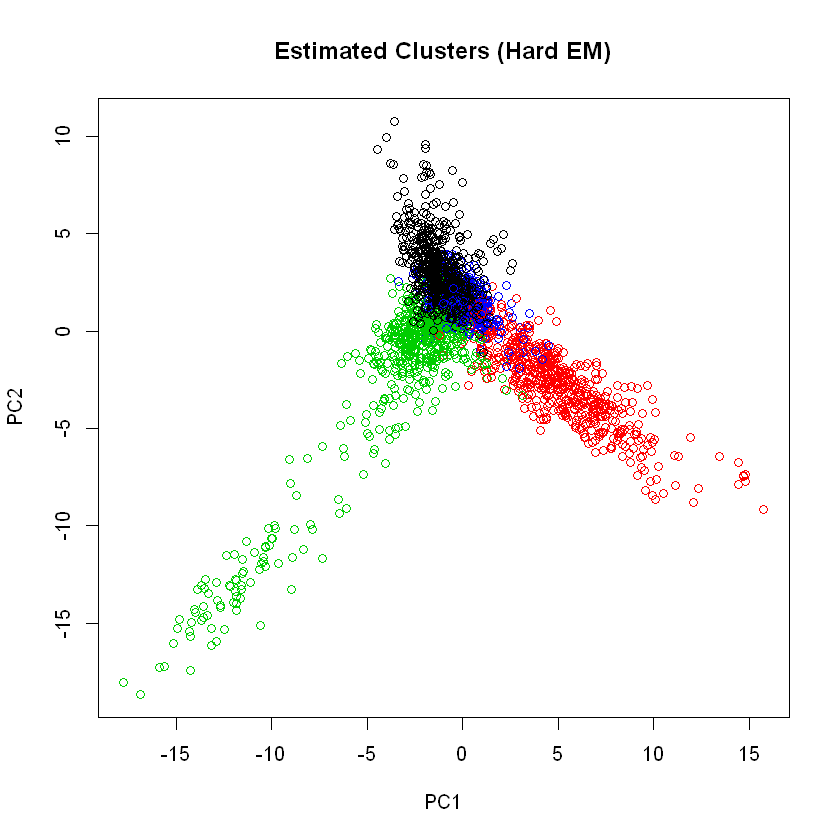

In [3]:
# word-document frequency matrix 
counts <- data$word.doc.mat  
# calling the hard EM algorithm on the data
res <- EM(counts, K=4, max.epoch=20, mode=2)
# because of logSum(), the max probability is not 1 but 2.718282
label.hat <- apply(res$gamma, 1, which.max) 
counts<-scale(counts)
hardEM <- cluster.viz(t(counts), label.hat, 'Estimated Clusters (Hard EM)')
hardEM

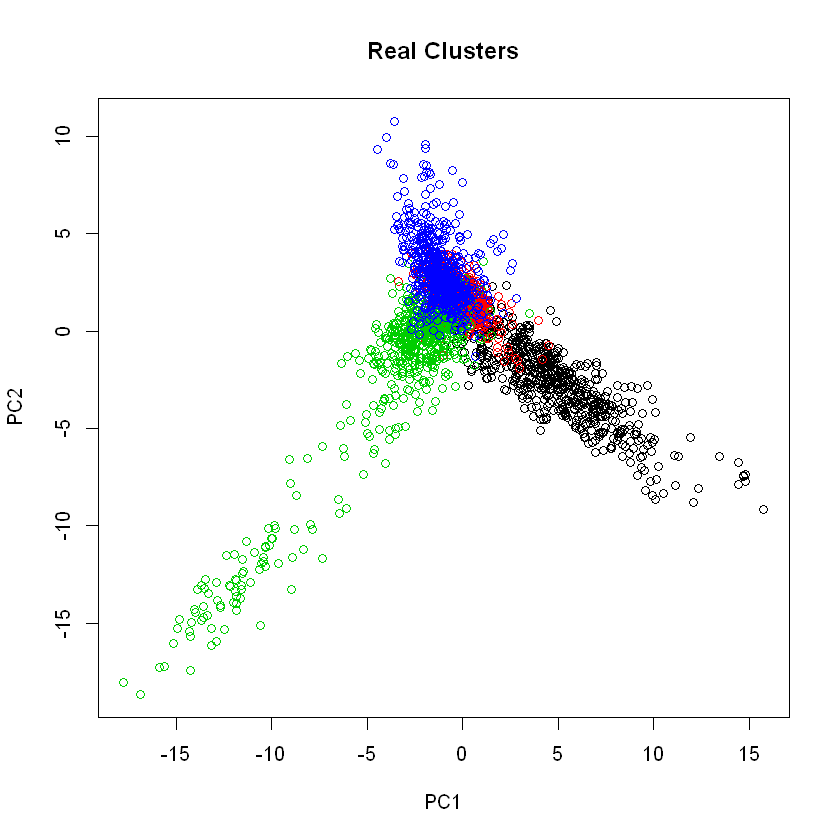

In [4]:
## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')

# Part B. Neural Network vs. Perceptron
In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.

## Question 2 [Neural Network’s Decision Boundary, 30 Marks]

In [5]:
## Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

Warning message:
"package 'ggplot2' was built under R version 3.3.3"
Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate

Warning message:
"package 'reshape2' was built under R version 3.3.3"

In [6]:
# --------------------------------------
#
# Code is from the code base provided.
#
# --------------------------------------

####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

**Q2.1)** Load __Task3B_train.csv__ and Task3B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your report.

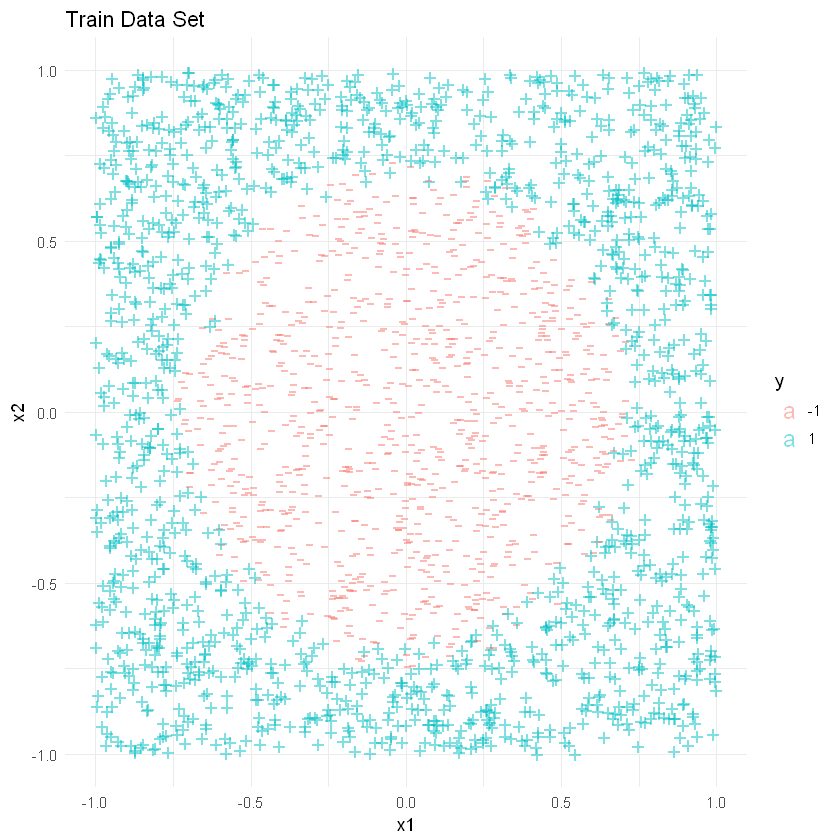

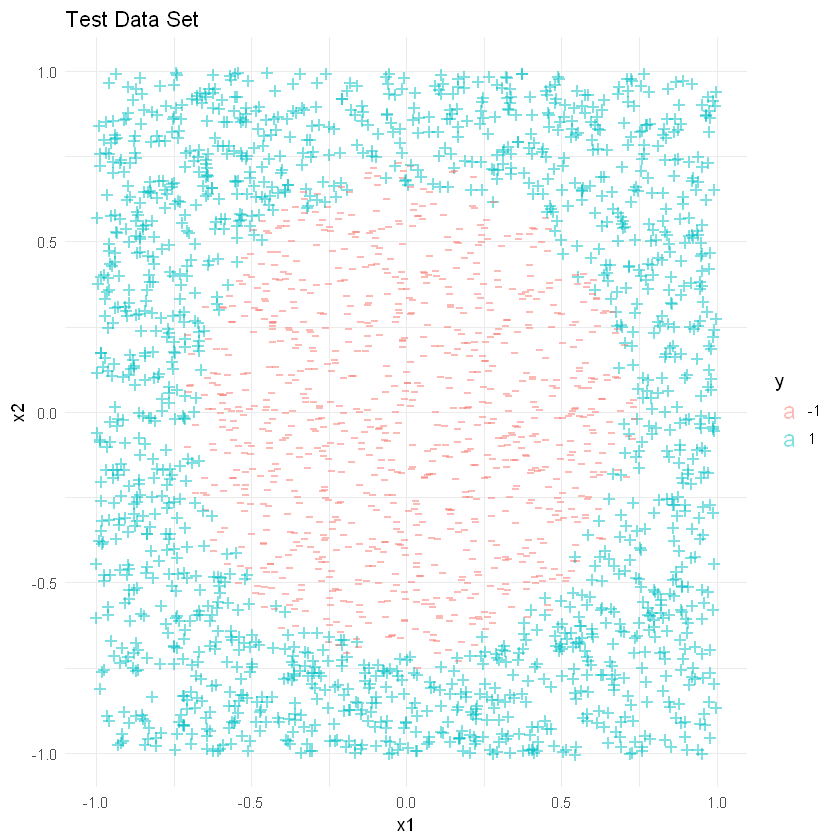

In [7]:
# Read the datasets
set.seed(1234)          # set random seed
library(ggplot2)        # load libraries
list[X1,T1] <- read.data('Task3B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('Task3B_test.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 

X1.label <- as.character(T1)
X2.label <- as.character(T2)
X1.data <- data.frame(x1 = X1$x1, x2 = X1$x2, y = X1.label)
X2.data <- data.frame(x1 = X2$x1, x2 = X2$x2, y = X2.label)

# Plot the Train Data Set
ggplot(data=X1.data, 
       aes(x=x1, y=x2, color=y, label=ifelse(y=='-1', '-', '+'))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Train Data Set') +
    theme_minimal()

# Plot the Test Data Set
ggplot(data=X2.data, 
       aes(x=x1, y=x2, color=y, label=ifelse(y=='-1', '-', '+'))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Test Data Set') +
    theme_minimal()

**Q2.2)** Run the implementations of Perceptron given to you in Activity 3.1, calculate the test error, and plot the test data while the points are colored with their estimated class labels; attach the pdf to your report.

In [8]:
######################################### PERCEPTRON ########################################
perceptron.predict <- function(Phi, W){
    return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
    return((W%*%Phi)*T1<0)
}
## Perceptron Build function
perceptron.build <- function(X1, T1, X2, T2, W, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
    if (length(unique(T1))!=2 & length(unique(T2)) != 2){
        stop("Perceptron: The input data is not a binary classification problem.")
    }
    if (all(sort(unique(T1)) != c(-1, 1)) & all(sort(unique(T2)) != c(-1, 1))) {
        stop("Perceptron: The labels are not (-1, +1).")
    }

    N1 <- nrow(X1)
    Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0
    Phi2 <- as.matrix(cbind(1, X2)) # add a column of 1 as phi_0

    W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
    W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
    error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
    error.rec[1] <- error.rate(perceptron.predict(Phi2, W[1,]), T2) # record error for initial weights
    tau <- 1 # iteration counter 
    terminate <- FALSE # termination status

    while(!terminate){
        # resuffling train data and associated labels:
        indx <- sample(1:N1, replace = FALSE)
        Phi <- Phi[indx,]
        T1 <- T1[indx]

        for (i in 1:N1){
          if (tau >= tau.max) {break}
          # look for missclassified samples
          if (is.a.miss(Phi[i,], W[tau,], T1[i])){
            tau <- tau +1                                 # update tau counter
            W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
            error.rec[tau] <- error.rate(perceptron.predict(Phi2, W[tau,]), T2)# update the records
            eta = eta * 0.99                                 # decrease eta
          } 
        }

        # recalculate termination conditions
        terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )

    }
    if (plotting){
        plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
    }
    
    W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)


    return(list(Weights = W[nrow(W),], Error = error.rec[tau]))         # return the last weight vector
}


[1] 0.009107961 0.084309368 0.064358194

[1] 0.514

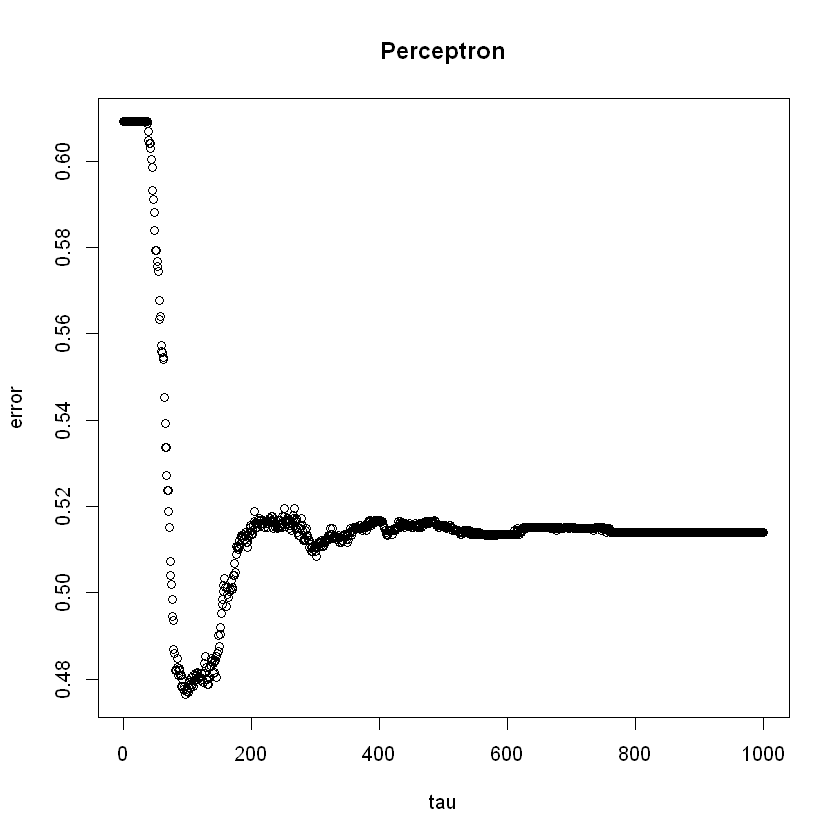

In [9]:
Phi1 <- as.matrix(cbind(1, X1))
Phi2 <- as.matrix(cbind(1, X2))
resp <- perceptron.build(X1, T1, X2, T2, tau.max = 1000, plotting = TRUE) # Run this a few times until you are happy with the result
resp$Weights
resp$Error

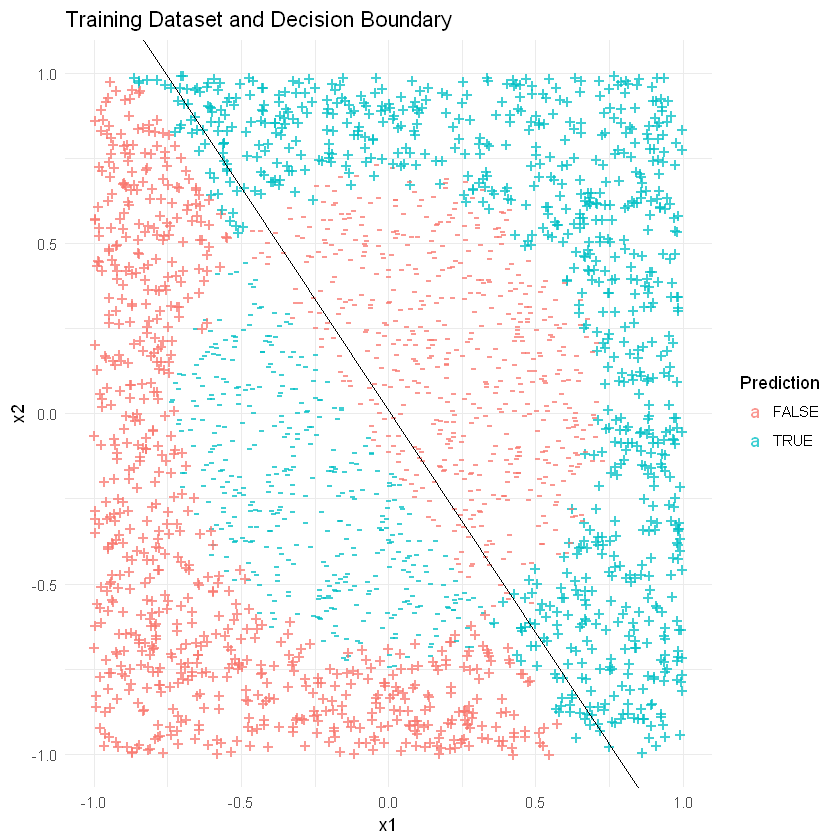

In [10]:
# Visualizations
## Plotting the decision boundary
ggplot(data=X1, aes(x=x1, y=x2, label=ifelse(T1!=-1, '+', '-'), color=factor(Phi1%*%resp$Weights*T1>0))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    geom_abline(intercept=resp$Weights[1], slope=-resp$Weights[2]/resp$Weights[3]) +
    ggtitle('Training Dataset and Decision Boundary') +
    theme_minimal()

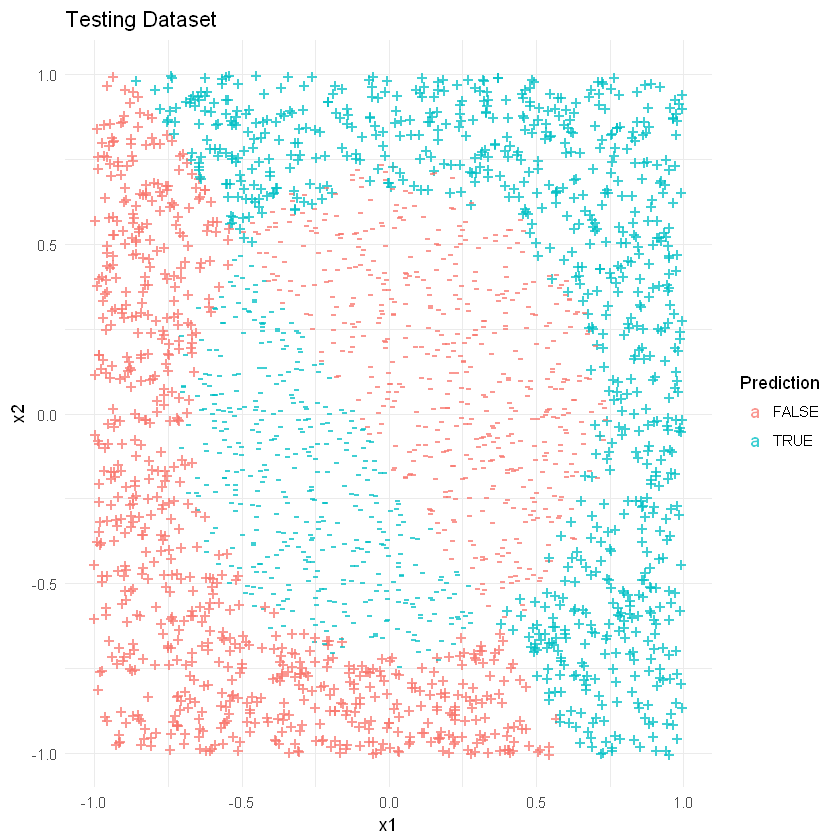

In [11]:
## Plotting the decision boundary
ggplot(data=X2, aes(x=x1, y=x2, label=ifelse(T2!=-1, '+', '-'), color=factor(Phi2%*%resp$Weights*T2>0))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Testing Dataset') +
    theme_minimal()

In [12]:
cat("Perceptron Train Error: ", error.rate(perceptron.predict(Phi1, resp$Weights), T1))
# Perceptron error in the Test Data
cat("\n\nPerceptron Test Error: ", error.rate(perceptron.predict(Phi2, resp$Weights), T2))

Perceptron Train Error:  0.512

Perceptron Test Error:  0.514

**Q2.3)** Run the 3-layer Neural Network given to you in Activity 5.1 with different values of K (i.e, number of units in the hidden layer) and record testing error for each of them; plot the error vs K and attach it to your report. Based on this plot, find the best K and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected.

In [13]:
####################### NEURAL NETWORK ####################### 
## the activation function (tanh here)
# revised accdg to the formula in Alexandria
h <- function(z) {
  return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function (tanh here)
# revised accdg to the formula in Alexandria
h.d <- function(z) {
  return (1-(h(z))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d(z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){
        error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)
    }
  }
  if(plotting){  
      plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  }
  return(list(W1, W2, b1, b2))
}

In [14]:
# transfrom the training and testing data by transposing t()
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))

# create a list of k that provides the number of hidden layer nodes
#
# NOTE: this was supposed to be seq(2, 100, 2) but my computer runs FOREVER if i do this.
# I had to decrease the number of k so my computer (and I) won't go insane while waiting
#
K <- seq(2, 100, 10)
error.rec <- as.data.frame(matrix(NA,nrow=length(K), ncol=2))
names(error.rec) <- c('k', 'error')
i <- 1

# create a neural network model per k
for (k in K) {
    
    # build the neural network model
    list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=FALSE, epoch.max=500, eta = 0.1, lambda = 0.01)

    # evaluate the model using the test set
    error.rec[i, 'k'] <- k
    error.rec[i, 'error'] <- error.rate(nn.predict(X2.t, W1, W2, b1, b2), T2)

    # record the test errors for plotting purposes
    i <- i + 1
}

**Q2.4)** In a table, report the error rates obtained by the perceptron and all variants of NN. Then bold the best model (with minimum error).

In [15]:
# Re-print Perceptron test error
cat("\n\nPerceptron Test Error: ", error.rate(perceptron.predict(Phi2, resp$Weights), T2))

# Neural Network test errors
error.rec



Perceptron Test Error:  0.514

k,error
2,0.3908
12,0.2356
22,0.0524
32,0.0468
42,0.0412
52,0.0472
62,0.0444
72,0.1460
82,0.1076
92,0.1156


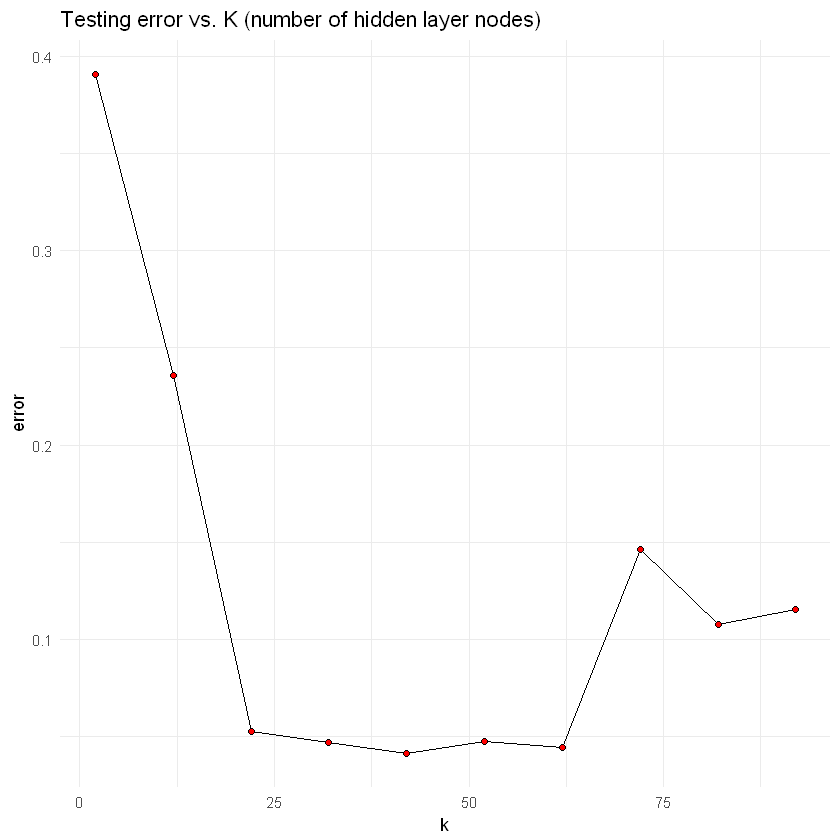

In [16]:
ggplot(data=error.rec,aes(x=k, y=error)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Testing error vs. K (number of hidden layer nodes)') + theme_minimal()

In [17]:
cat("Best Neural Network Model:")
error.rec[error.rec$error == min(error.rec$error),]
bestK <- error.rec[error.rec$error == min(error.rec$error),]$k
cat("\nBest K:", bestK)

Best Neural Network Model:

,k,error
5,42,0.0412



Best K: 42

In [19]:
# Redo the best k to get the weights
list[kW1, kW2, kb1, kb2] <-  nn.build(bestK, X1.t, T1, plotting=FALSE, epoch.max=500, eta = 0.1, lambda = 0.01)

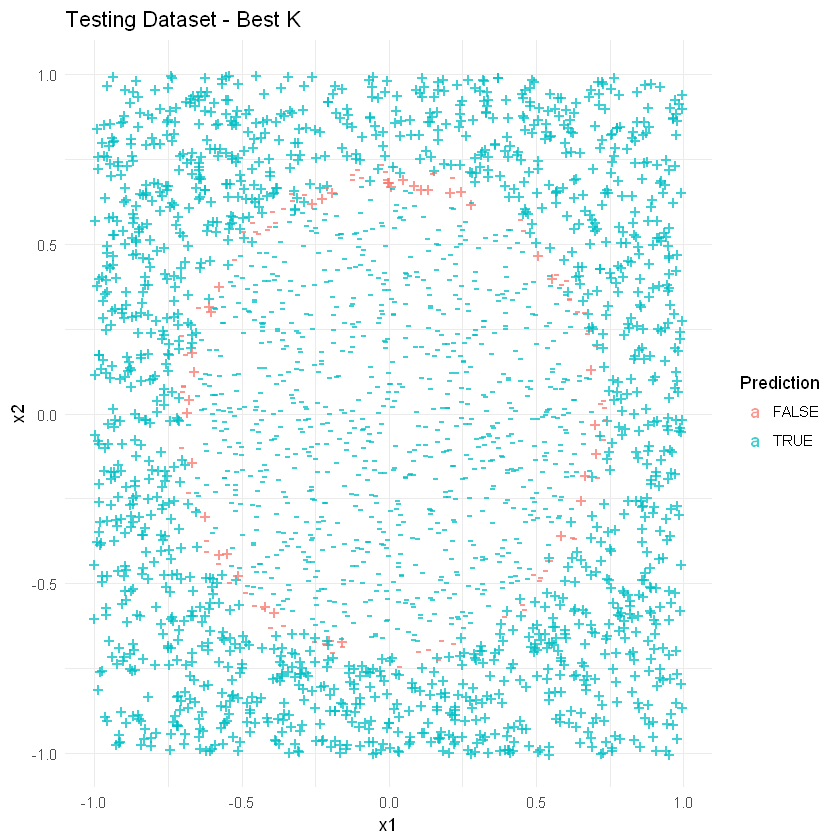

In [20]:
## Plotting the decision boundary
ggplot(data=X2, aes(x=x1, y=x2, label=ifelse(T2!=-1, '+', '-'), color=factor(nn.predict(X2.t, kW1, kW2, kb1, kb2) == T2))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Testing Dataset - Best K') +
    theme_minimal()

**Q2.5)** Explain the reason(s) responsible for such difference between perceptron and a 3-layer NN. __Hint:__ Look at the plots and think about the model assumptions.

Perceptron only works for <u>linearly separable classes</u>; on the other hand, neural network can detect more complex decision boundaries. Perceptron uses the <u>step function as the activation function</u>, while the neural network's activation function is the non-linear `tanh()` function, which <u>produces non-linear hidden units</u>. Since the assessment data is non-linear, the perceptron does a poor job of classification\* but the neural network learned the correct decision boundary.


\* the resulting decision boundary made by the perceptron is a line as expected, while neural network could discern the circular boundary

# Part C. Self-Taught Learning
In this part, you implement self-taught learning for Neural Network using the Autoencoder that provided in Activity 5.2 and the 3-layer NN from Activity 5.1.
## Question 3 [Self Taught Neural Network Learning, 30 Marks]
**Q3.1)** Load __Task3C_labeled.csv__, __Task3C_unlabeled.csv__ and __Task3C_test.csv__ data sets and required libraries (e.g., H2O). __Note__ that we are going to use __Task3C_labeled.csv__ and __Task3C_unlabeled.csv__ for training the autoencoder. We are going to use Task3C_labeled.csv for training the classifier. Finally, we evaluate the trained classifier on the test Task3C_test.csv.

In [21]:
# read the data
train3C.labeled <- read.csv('Task3C_labeled.csv')
train3C.unlabeled <- read.csv('Task3C_unlabeled.csv')
train3C.test <- read.csv('Task3C_test.csv')

In [22]:
library(h2o)

# initialise h2o instance
localH2O <- h2o.init(nthreads = -1, port = 54321, startH2O = FALSE, max_mem_size = '6G', strict_version_check = FALSE)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         9 minutes 12 seconds 
    H2O cluster version:        3.15.0.4046 
    H2O cluster version age:    9 days  
    H2O cluster name:           mrkjse 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.44 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.3.2 (2016-10-31) 



In [23]:
# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.path <- 'C:/Users/mrkjse/Documents/Monash/5201/assignment3/Task3C_labeled.csv'
unlabeled.path <- 'C:/Users/mrkjse/Documents/Monash/5201/assignment3/Task3C_unlabeled.csv'
test.path <- 'C:/Users/mrkjse/Documents/Monash/5201/assignment3/Task3C_test.csv'

labeled.frame <- h2o.importFile(path = labeled.path,sep=',') 
unlabeled.frame <- h2o.importFile(path = unlabeled.path,sep=',') 
test.frame <- h2o.importFile(path = test.path,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [24]:
# for testing
#K <- c(20, 80, 150)

# Auxiliary Function for NN prediction
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

# create a list of Ks or the number of hidden layer nodes
K <- seq(2, 50, 1)
error.rec <- as.data.frame(matrix(NA,nrow=length(K), ncol=3))
names(error.rec) <- c('k', 'errorAE', 'errorNN')
K

[1]  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
[26] 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

**Q3.2)** Build an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons from 2 to 500.

**Q3.5)** Build augmented self-taught networks using the models learnt in Step II. For each model:
   1. Add the output of the middle layer as extra features to the original featureset, 
   2. Train a 3-layer NN (similar to Step IV) using all features (original + extra).Then calculate and record the test error.

In [25]:
options(warn=-1)
i <- 1
for (k in K){
    # Question 3.2 - Create Autoencoder Model
    autoencoder <- h2o.deeplearning(    
                        x = 1:784, # select all pixels
                        training_frame = train.frame, # specify the frame (imported file)    
                        hidden = c(k), # number of layers and their units
                        epochs = 100, # maximum number of epochs  
                        activation = 'Tanh', # activation function 
                        autoencoder = TRUE  # is it an autoencoder? Yes!
                    )
    
    # Question 3.3 - Record Autoencoder Error
    error.rec[i, 'k'] <- k
    error.rec[i, 'errorAE'] <- mean(h2o.anomaly(autoencoder, train.frame))
    
    # Question 3.5 - Create a self augmented Neural Network
    updated.train <- h2o.cbind(labeled.frame, h2o.deepfeatures(autoencoder, labeled.frame, 1))
    updated.train[,1] <- as.factor(updated.train[,1])

    nn <- h2o.deeplearning(    
              x = 2:ncol(updated.train), # select all pixels + extra features
              y = 1,
              training_frame = updated.train, # specify the frame (imported file)    
              hidden = c(10), # number of layers and their units
              epochs = 50, # maximum number of epochs  
              activation = 'Tanh', # activation function 
              autoencoder = FALSE, # is it an autoencoder? No
              l2 = 0.1)
    
    # Make predictions from the neural network model
    test.predict <- h2o.predict(nn, test.frame)$predict
    
    # Record the test error
    error.rec[i, 'errorNN'] <- error.rate(test.frame$label, test.predict)
    
    i <- i + 1
    
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

**Q3.3)** For each model in Step II, calculate and record the reconstruction error which is simply the average (over all data points while the model is fixed) of Euclidian distances between the input and output of the autoencoder (you can simply use “h2o.anomaly()” function). Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. 

In [26]:
error.rec

k,errorAE,errorNN
2,0.036777003,0.456
3,0.036140983,0.414
4,0.031647824,0.375
5,0.028561879,0.398
6,0.029230714,0.383
7,0.022217435,0.396
8,0.030017694,0.408
9,0.020480412,0.391
10,0.038440546,0.411
11,0.035527455,0.374


In [27]:
# Retrieve the best number of hidden layer nodes for autoencoder
cat("Best Autoencoder Model:")
error.rec[error.rec$errorAE == min(error.rec$errorAE),]
bestK <- error.rec[error.rec$errorAE == min(error.rec$errorAE),]$k
cat("\nBest Autoencoder K:", bestK)

# Retrieve the best number of hidden layer nodes for neural network
cat("\n\nBest Neural Network Model:")
error.rec[error.rec$errorNN == min(error.rec$errorNN),]
bestK <- error.rec[error.rec$errorNN == min(error.rec$errorNN),]$k
cat("\nBest Neural Network K:", bestK)


Best Autoencoder Model:

,k,errorAE,errorNN
44,45,0.00428542,0.366



Best Autoencoder K: 45

Best Neural Network Model:

,k,errorAE,errorNN
25,26,0.01481578,0.342



Best Neural Network K: 26

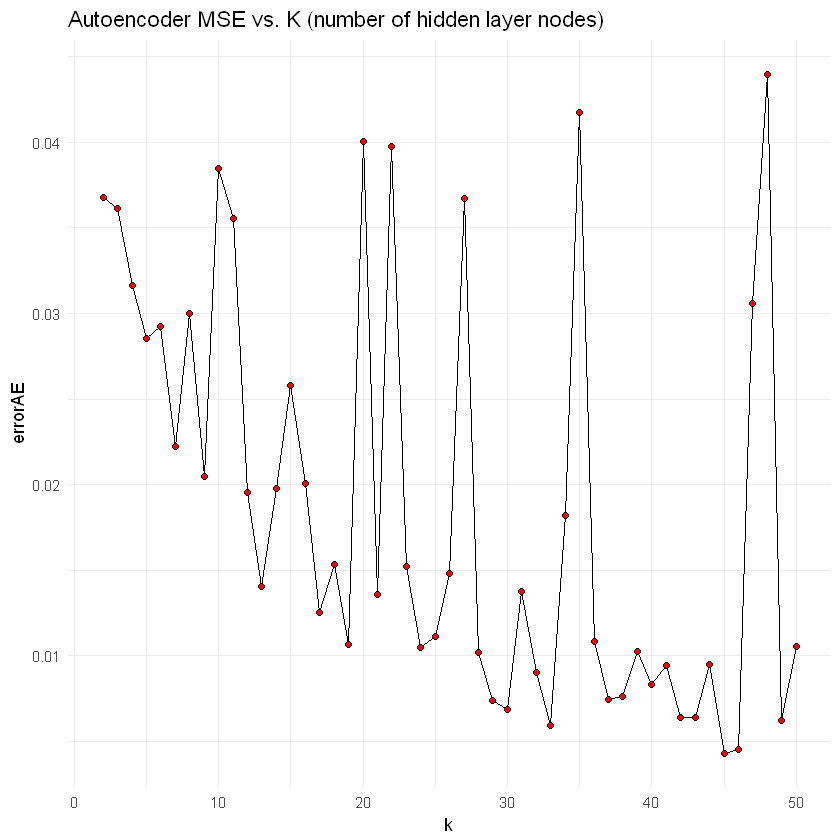

In [28]:
# Plot the autoencoder errors
library(ggplot2)
ggplot(data=error.rec[,1:2],aes(x=k, y=errorAE)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Autoencoder MSE vs. K (number of hidden layer nodes)') + theme_minimal()

In terms of the reconstruction error, <u>as the number of hidden layer nodes increase, the error decreases</u>. There were certain fluctuations in the errors but in general the more number of hidden layer nodes the smaller the possible error is. Based on the error values above the autoencoder was able to capture the training dataset very well because the errors are at most 0.045~ which can be considered quite low.

**Q3.4)** Use the 3-layer NN from Activity 3.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) build a model with 100 units in the hidden layer. Then, calculate and record the test error.

In [29]:
NN.model <- h2o.deeplearning(    
      x = 2:ncol(labeled.frame), # select all pixels + extra features
      y = 1,
      training_frame = labeled.frame, # specify the frame (imported file)    
      hidden = c(100), # number of layers and their units
      epochs = 50, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = FALSE, # is it an autoencoder? No
      l2 = 0.1 )

labeled.predict <- h2o.predict(NN.model, labeled.frame)$predict
error.rate(labeled.frame$label, labeled.predict)

test.predict <- h2o.predict(NN.model, test.frame)$predict
error <- error.rate(test.frame$label, test.predict)
error

  |======================================================================| 100%
  |======================================================================| 100%


[1] 0

  |======================================================================| 100%


[1] 0.555

**Q3.5)** Is together with **Q3.2**.

**Q3.6)** Plot the error rates for the 3-layer neural networks from Step IV and V while the x-axis is the number of features and y-axis is the classification error. 

**Q3.7)** Report the optimum number(s) of units in the middle layer of the autoencoder in terms of the reconstruction and misclassification errors.

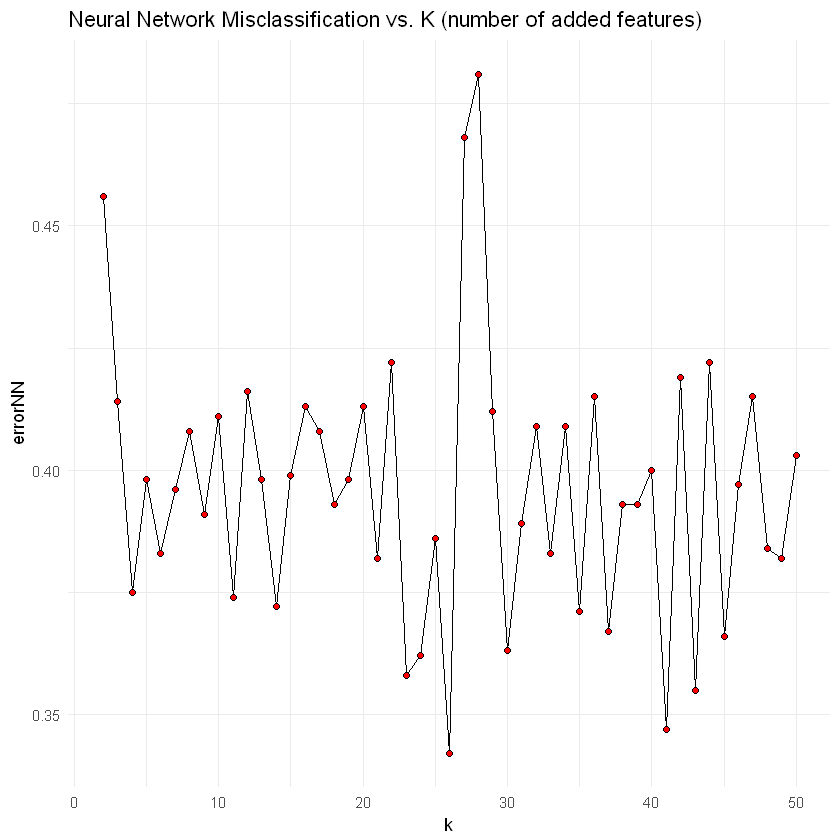

In [30]:
# Plot the neural network errors
ggplot(data=error.rec[,c(1,3)],aes(x=k, y=errorNN)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Neural Network Misclassification vs. K (number of added features)') + theme_minimal()

In terms of the misclassification error, the error is quite high which suggests overfitting to the training data. The additional features do not help improve the neural network performance.

**Q3.8)** Comparing the plot from Step III and VI, do you observe any relation between the reconstruction error and misclassification error? Explain your findings.

In this case, it is hard to discern if there is any relationship between the reconstruction error and the misclassification error. As the number of hidden layer nodes increase, the misclassification error fluctuates whereas the reconstruction error decreases in general. I would presume that the misclassification error should also decrease similarly with the reconstruction error (as more features of the data were added) but it did not happen because the autoencoder's hidden features overfit the `training.frame` data.

__Hint.__ Since the dataset for this task is large and high-dimensional, running the whole
experiments several times is very time consuming. Therefore, it is recommended to only use a small portion of your data when you develop or debug your code.

__Hint.__ If you can combine Step II and V (so learn each autoencoder only once), you may save a great portion of the execution time.

__Hint.__ If you don’t see the expected behaviour in your plots, you may need to check that the data is clean, i.e. it does'nt have NA entries, it’s normalised etc. Moreover, you may need to check that your implementation of the model and training/decoding algorithms is correct.
